# MNIST with CNN

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
from tensorflow.examples.tutorials.mnist import input_data

In [27]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [28]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [29]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.


In [30]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Create a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 

In [31]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [32]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [33]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Placeholders

In [34]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [35]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

### Layers

In [36]:
x_image = tf.reshape(x,[-1,28,28,1])

In [37]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of 
# a single image.
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [38]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [39]:
# Why 7 by 7 image? Because we did 2 pooling layers, so (28/2)/2 = 7
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [40]:
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [41]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [42]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer

In [43]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [44]:
init = tf.global_variables_initializer()
saver = tf.train.Saver() 

### Session

In [21]:
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = mnist.train.next_batch(50)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))
            print('\n')
            
    saver.save(sess, "./savedModels/CNNMNISTModel.ckpt") 

Currently on step 0
Accuracy is:
0.1016


Currently on step 100
Accuracy is:
0.8557


Currently on step 200
Accuracy is:
0.9026


Currently on step 300
Accuracy is:
0.9253


Currently on step 400
Accuracy is:
0.9355


Currently on step 500
Accuracy is:
0.9426


Currently on step 600
Accuracy is:
0.9504


Currently on step 700
Accuracy is:
0.9572


Currently on step 800
Accuracy is:
0.9581


Currently on step 900
Accuracy is:
0.9604


Currently on step 1000
Accuracy is:
0.9643


Currently on step 1100
Accuracy is:
0.9652


Currently on step 1200
Accuracy is:
0.9664


Currently on step 1300
Accuracy is:
0.968


Currently on step 1400
Accuracy is:
0.9682


Currently on step 1500
Accuracy is:
0.9702


Currently on step 1600
Accuracy is:
0.9712


Currently on step 1700
Accuracy is:
0.973


Currently on step 1800
Accuracy is:
0.9734


Currently on step 1900
Accuracy is:
0.9753


Currently on step 2000
Accuracy is:
0.9763


Currently on step 2100
Accuracy is:
0.9758


Currently on step 2200
A

## Single Prediction

In [45]:
def predict(image):
    
    
    image = image.reshape((1,-1))

    with tf.Session() as sess:
        
        sess.run(init)
    
        saver.restore(sess,"./savedModels/CNNMNISTModel.ckpt")
        
        prediction = tf.argmax(y_pred,1)
        results = y_pred.eval(feed_dict={x:image,hold_prob:1.0})
        
    return np.argmax(results)

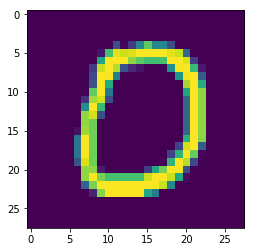

In [46]:
image = mnist.test.images[10]
plt.imshow(image.reshape(28,28))

In [47]:
prediction = predict(image)
print(prediction)

INFO:tensorflow:Restoring parameters from ./savedModels/CNNMNISTModel.ckpt
0


In [48]:
image.shape

(784,)

In [116]:
import matplotlib.image as mpimg
import PIL.Image as Image
import PIL.ImageOps

In [146]:
img = Image.open('seven.png',mode='r')

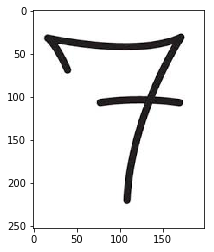

In [147]:
plt.imshow(img)

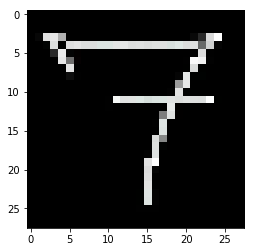

In [148]:
img = img.resize((28,28))
img = PIL.ImageOps.invert(img)
plt.imshow(img)

In [149]:
img = img.convert('L')
img = np.asarray(img)

In [150]:
img.shape

(28, 28)

In [151]:
img = img.flatten()

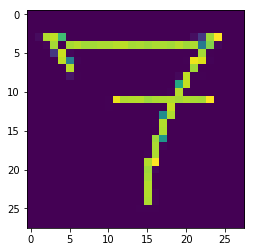

In [152]:
plt.imshow(img.reshape(28,28))

In [153]:
prediction = predict(img)
print(prediction)

INFO:tensorflow:Restoring parameters from ./savedModels/CNNMNISTModel.ckpt
7
